# Object Detection try 2

>Quelle: https://github.com/kaa/coins-dataset

In [1]:
import cv2
import numpy as np

import __main__ as main

import matplotlib.pyplot as plt
from keras.preprocessing.image import img_to_array
from tensorflow import keras

ModuleNotFoundError: No module named 'cv2'

In [203]:
def loadImage(src):
    img = cv2.imread(src)
    if not img is None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [204]:
def findCoins(img, showCoins = False):
    scaling = 600.0/max(img.shape[0:2])
    #print (scaling)
    img_gray = cv2.resize(img, None, fx=scaling, fy=scaling)
    img_gray = cv2.cvtColor(img_gray, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.blur(img_gray, (5,5))
    coins = cv2.HoughCircles(img_gray, cv2.HOUGH_GRADIENT, 1.2, 30, param2 = 35, minRadius = 20, maxRadius = 50)
    coins = (np.round(coins[0,:]) / scaling).astype("int")
    return coins

In [205]:
local_img="real_test_data/multi/IMG_20220620_105307.jpg"
colab_img="/content/Coins/real_test_data/multi/IMG_20220620_105307.jpg"

local_model_dir = "Models/Tuned/tuned_model"
colab_model_dir = "/content/Coins/Models/Tuned/tuned_model"

In [206]:
model_loaded = keras.models.load_model(local_model_dir)

In [207]:
img = loadImage(local_img)

In [208]:
coins = findCoins(img, showCoins = True)
len(coins)

17

In [209]:
def adjust_gamma(image, gamma=1.0):

   invGamma = 1.0 / gamma
   table = np.array([((i / 255.0) ** invGamma) * 255
      for i in np.arange(0, 256)]).astype("uint8")

   return cv2.LUT(image, table)

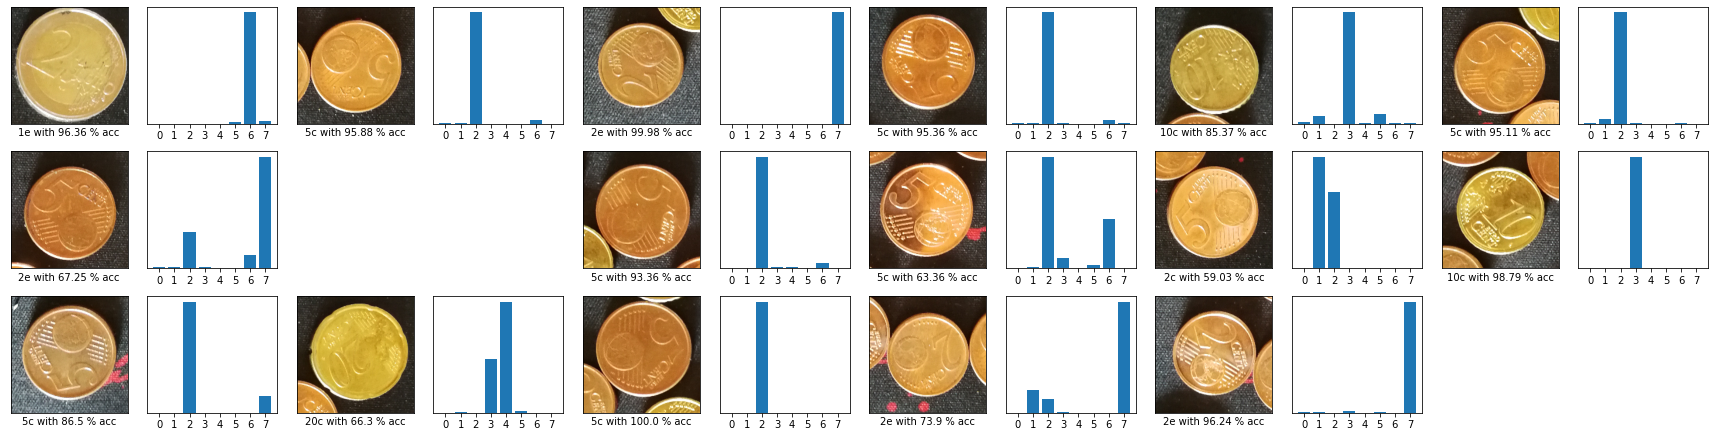

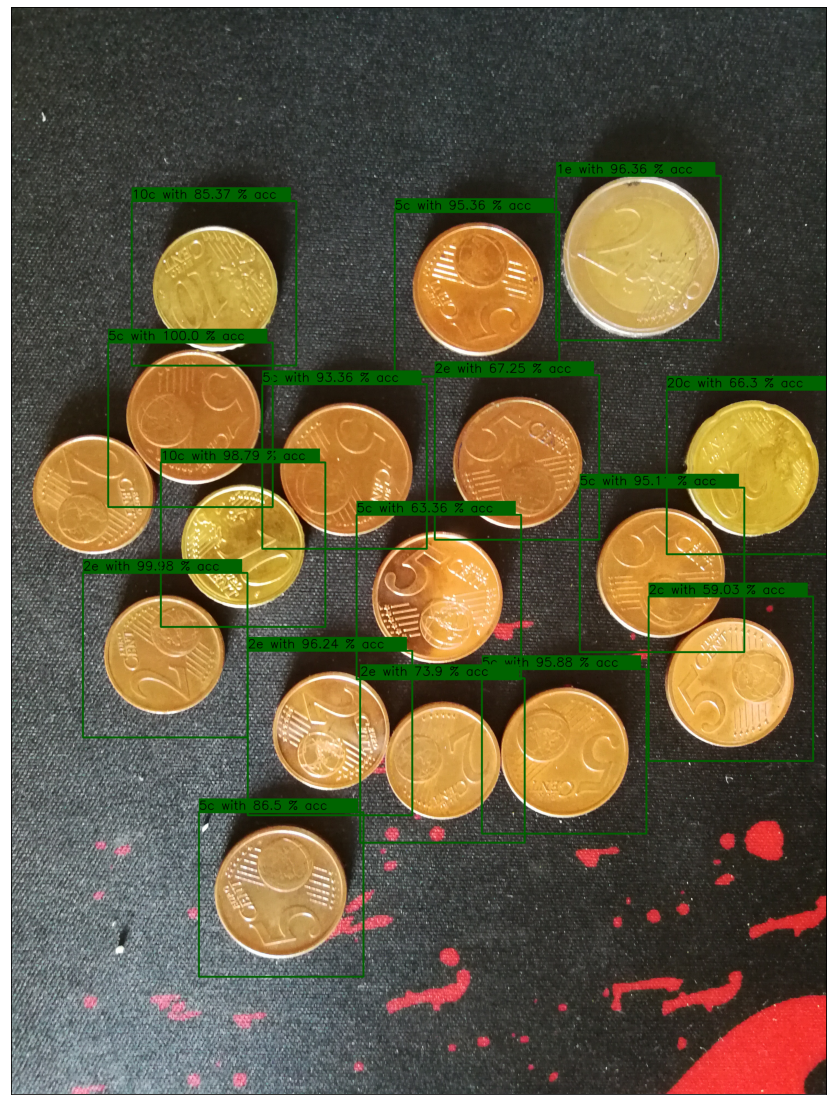

In [210]:
maxRadius = np.amax(coins,0)[2]+10

class_names=["1c", "2c", "5c", "10c", "20c", "50c", "1e", "2e"]
n=int(len(coins)/2)
num_rows = n+2
num_cols = n-2
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols,2*num_rows))

clone = img.copy()

for i,(x,y,r) in enumerate(coins):
    img_coin = img[y-maxRadius:y+maxRadius, x-maxRadius:x+maxRadius]
    if img_coin.shape[0]==0 or img_coin.shape[1]==0:
        continue

    img_coin = cv2.resize(img_coin, (200,200))
    img_x = adjust_gamma(img_coin, gamma=1)    #Gamma Experiment: Je nach Gamma-Wert Performed das Modell besser oder Schlechter. Stark vom Bild abhängig
    img_x = img_to_array(img_x)                    
    img_x = img_x.reshape((1,) + img_x.shape)

    s_prediction = model_loaded.predict(img_x)
    pred = f"{class_names[np.argmax(s_prediction)]} with { (100 * np.max(s_prediction)).round(2) } % acc"

    plt.subplot(num_rows,2*num_cols, 2*i+1)
    plt.yticks([])
    plt.xticks([])
    plt.xlabel(pred)
    plt.imshow(img_coin)

    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plt.xticks(range(8))
    plt.yticks([])
    plt.bar(range(8),s_prediction[0])

    cv2.rectangle(clone, (x-maxRadius, y-maxRadius), (x+maxRadius, y+maxRadius),(0,100,0), 5)
    cv2.rectangle(clone,(x-maxRadius, y-maxRadius),(x+maxRadius-20,y-maxRadius-50),(0,100,0),-1)
    cv2.putText(clone, pred, (x-maxRadius, y-maxRadius-10),cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 0), 2)
    
plt.tight_layout()
plt.show()

plt.figure(figsize=(30,20))
plt.xticks([])
plt.yticks([])
plt.imshow(clone)
plt.show()